# Predicting Glassdoor Evaluation from Job

This notebook presents the work on data preparation, preprocessing and modeling for the paper on predicting Glassdoor evaluations. 

The notebook was prepared by David Søbæk Olsen (daol@itu.dk), Gustav Michael Løfstrøm Jandrup (gusj@itu.dk) and Klara Pauline Søgaard Jensen (klpj@itu.dk).

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import researchpy as rp
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import BernoulliNB
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpmax

from kmodes.kmodes import KModes

from collections import Counter

## INITIAL DATA PREPARATION

In [2]:
# load the data set
df = pd.read_csv('glassdoor_reviews.csv', sep = ',')

In [3]:
# Dropping diversity and inclusion column due to vast number of NaN values
df_glassdoor = df.drop('diversity_inclusion', axis = 1)

# Removing all observations from 'Anonymous Employees'
df_glassdoor = df_glassdoor[df_glassdoor["job_title"].str.contains("Anonymous Employee") == False] 

# Replacing empty cells with NaN values
df_glassdoor['job_title'] = df_glassdoor['job_title'].str.strip().replace('', np.nan)

In [4]:
# Finding the 20 most frequent job titles
df_glassdoor['job_title'].value_counts()[:20]

Manager                            15209
Consultant                         12646
Software Engineer                  10899
Associate                          10420
Senior Consultant                  10282
Analyst                             9732
Crew Member                         7764
Senior Associate                    7348
Cashier                             5861
Vice President                      5597
Senior Manager                      5431
Customer Assistant                  5402
Project Manager                     5400
Sales Assistant                     5332
Director                            5272
Assistant Manager                   5196
Senior Software Engineer            4979
Business Analyst                    4801
Customer Service Representative     4004
Sales Associate                     3488
Name: job_title, dtype: int64

In [5]:
# Creating a new dataframe for the models
modeldf = df_glassdoor.copy()

In [6]:
# Converting ratings from 1 to 5 to binary form
modeldf = modeldf.replace(1.0, 0)
modeldf = modeldf.replace(2.0, 0)
modeldf = modeldf.replace(3.0, 0)
modeldf = modeldf.replace(4.0, 1)
modeldf = modeldf.replace(5.0, 1)

In [7]:
# Splitting 'current' column into 'current' and 'tenure'
modeldf[['current','tenure']] = modeldf['current'].str.split(',', expand = True)

In [8]:
# Replace empty values with NaN
modeldf = modeldf.replace(to_replace=[None], value=np.nan)

# Strip whitespace from 'tenure' column
modeldf['tenure'] = modeldf['tenure'].str.strip()

In [9]:
# Replace strings with integers in 'tenure' column
modeldf.replace("more than 1 year", "1", inplace = True)
modeldf.replace("more than 3 years", "3", inplace = True)
modeldf.replace("more than 5 years", "5", inplace = True)
modeldf.replace("more than 8 years", "8", inplace = True)
modeldf.replace("more than 10 years", "10", inplace = True)
modeldf.replace("less than 1 year", "0", inplace = True)

In [10]:
# Converting 'current' column into binary form. Current: 1, former: 0.
modeldf.replace("KEY NOT FOUND: jobLine.per_diem-former", 0, inplace = True)
modeldf.replace("KEY NOT FOUND: jobLine.temporary-former", 0, inplace = True)
modeldf.replace("Former Employee", 0, inplace = True)
modeldf.replace("Former Contractor", 0, inplace = True)
modeldf.replace("Former Intern", 0, inplace = True)
modeldf.replace("Former Temporary Employee", 0, inplace = True)
modeldf.replace("Current Employee", 1, inplace = True)
modeldf.replace("Current Contractor", 1, inplace = True)
modeldf.replace("Current Intern", 1, inplace = True)
modeldf.replace("Current Freelancer", 1, inplace = True)

## DESCRIPTIVE STATISTICS & EDA

In [11]:
jobsummary = df['job_title']
rp.summary_cat(jobsummary).head(10)

,Variable,Outcome,Count,Percent
0,job_title,Anonymous Employee,162649,19.40
1,,,79065,9.43
2,,Manager,14906,1.78
3,,Consultant,12559,1.50
4,,Software Engineer,10797,1.29
5,,Associate,10305,1.23
6,,Senior Consultant,10199,1.22
7,,Analyst,9680,1.15
8,,Crew Member,7759,0.93
9,,Senior Associate,6764,0.81


In [12]:
diversity = df['diversity_inclusion'].isna()
rp.summary_cat(diversity)

,Variable,Outcome,Count,Percent
0,diversity_inclusion,True,702500,83.77
1,,False,136066,16.23


In [13]:
summary = df_glassdoor[['overall_rating', 'culture_values', 'senior_mgmt', 'career_opp', 'work_life_balance', 'comp_benefits']]
rp.summary_cat(summary)

,Variable,Outcome,Count,Percent
0,overall_rating,4.0,222699,32.95
1,,5.0,190418,28.17
2,,3.0,154652,22.88
3,,2.0,60297,8.92
4,,1.0,47850,7.08
5,culture_values,5.0,172470,33.11
6,,4.0,135888,26.08
7,,3.0,104022,19.97
8,,1.0,56587,10.86
9,,2.0,52009,9.98


In [14]:
new_summary = modeldf[['overall_rating', 'culture_values', 'senior_mgmt', 'career_opp', 'work_life_balance', 'comp_benefits']]
rp.summary_cat(new_summary)

,Variable,Outcome,Count,Percent
0,overall_rating,1.0,413117,61.12
1,,0.0,262799,38.88
2,culture_values,1.0,308358,59.19
3,,0.0,212618,40.81
4,senior_mgmt,0.0,305692,54.87
5,,1.0,251414,45.13
6,career_opp,1.0,301204,53.46
7,,0.0,262244,46.54
8,work_life_balance,1.0,282533,50.33
9,,0.0,278817,49.67


<AxesSubplot:title={'center':'After converting overall ratings to binary form'}>

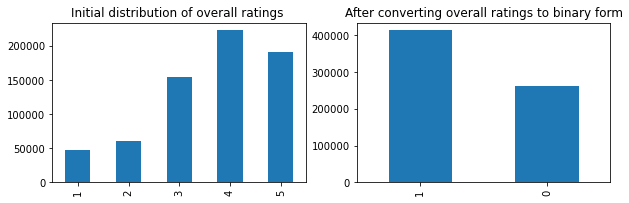

In [15]:
# Set up a grid of plots
fig = plt.figure(figsize=(10,10)) 
fig_dims = (3, 2)

# Plot rating distribution before and after converting to binary form
plt.subplot2grid(fig_dims, (0, 0))
df_glassdoor['overall_rating'].value_counts().sort_index().plot(kind='bar', 
                                     title='Initial distribution of overall ratings ')

plt.subplot2grid(fig_dims, (0, 1))
modeldf['overall_rating'].value_counts().plot(kind='bar', 
                                     title='After converting overall ratings to binary form')

In [ ]:
# Set up a grid of plots
new_df4 = ruleminingdf[['job_Business Professional', 'job_Management Professional', 'job_Service Professional', 'job_Technology Professional']]

fig2 = plt.figure(figsize = (10, 10)) 
fig_dims2 = (3, 2)

plt.subplot2grid(fig_dims2, (0, 0))
df_glassdoor['job_title'].value_counts()[:20].plot(kind='bar', 
                                     title='Twenty most frequent job titles')

plt.subplot2grid(fig_dims2, (0, 1))
new_df4.value_counts().plot(kind='bar', 
                                     title='Distribution of four labels')


## DATA PREPARATION FOR CLUSTERING (UNSUPERVISED)

In [16]:
# Create a dataframe for clustering model with just top 20 job titles
clusteringdf = modeldf[modeldf['job_title'].str.fullmatch('Manager|Consultant|Software Engineer|Associate|Senior Consultant|Analyst|Crew Member|Senior Associate|Cashier|Project Manager|Senior Manager|Vice President|Sales Assistant|Customer Assistant|Director|Assistant Manager|Senior Software Engineer|Business Analyst|Customer Service Representative|Sales Associate') == True]

# reset dataframe index from 0
clusteringdf = clusteringdf.reset_index(drop=True)

In [17]:
# Get dummies / Use one-hot encoding to get features describing job titles
clusteringdf = pd.get_dummies(clusteringdf, columns=['job_title'])

In [18]:
# Get dummmies for all other variables
clusteringdf = pd.get_dummies(clusteringdf, columns=['current'])
clusteringdf = pd.get_dummies(clusteringdf, columns=['overall_rating'])
clusteringdf = pd.get_dummies(clusteringdf, columns=['tenure'])
clusteringdf = pd.get_dummies(clusteringdf, columns=['work_life_balance'])
clusteringdf = pd.get_dummies(clusteringdf, columns=['culture_values'])
clusteringdf = pd.get_dummies(clusteringdf, columns=['career_opp'])
clusteringdf = pd.get_dummies(clusteringdf, columns=['comp_benefits'])
clusteringdf = pd.get_dummies(clusteringdf, columns=['senior_mgmt'])

In [19]:
# Drop columns not used for modelling
clusteringdf = clusteringdf.drop(['firm', 'date_review', 'location', 'recommend', 'ceo_approv', 'outlook', 'headline', 'pros', 'cons'], axis = 1)
clusteringdf.dropna(inplace = True) # Drop all NaN values
clusteringdf.astype('int') # Convert all values to integers to make sure there are no floats e.g. (1.0 or 0.0)

,job_title_Analyst,job_title_Assistant Manager,job_title_Associate,job_title_Business Analyst,job_title_Cashier,job_title_Consultant,job_title_Crew Member,job_title_Customer Assistant,job_title_Customer Service Representative,job_title_Director,...,work_life_balance_0.0,work_life_balance_1.0,culture_values_0.0,culture_values_1.0,career_opp_0.0,career_opp_1.0,comp_benefits_0.0,comp_benefits_1.0,senior_mgmt_0.0,senior_mgmt_1.0
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145058,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1
145059,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,0,1,0,0,1
145060,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1
145061,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Unsupervised ML Models: Clustering & Association Rules Mining

## CLUSTERING MODELING

In [20]:
# Create dataframe of rating features for clustering
feature_names = ["work_life_balance_1.0", "culture_values_1.0", "career_opp_1.0", "comp_benefits_1.0", "senior_mgmt_1.0"]
features = clusteringdf[feature_names]

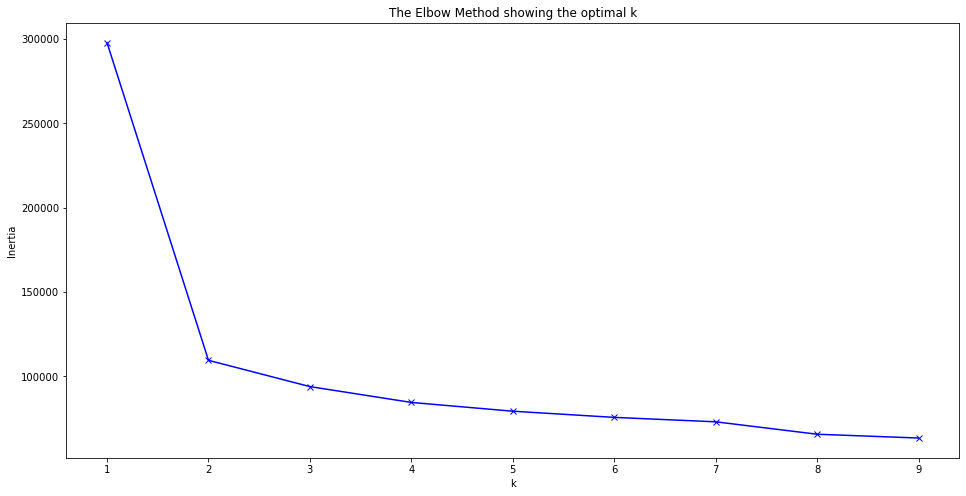

In [23]:
# Find optimal k value for k-Modes by plotting K over corresponding value of inertia (sum of square distances)
inertia = []
K = range(1,10) # range 1 - 10
for k in K: # for each value in range
    kmodes = KModes(n_clusters=k, init='Cao', n_init=10, n_jobs = 4) # initialize with Cao's init and attempt 10 iterations
    kmodes.fit(features) # fit the model
    inertia.append(kmodes.cost_) # append inertia

# Plot interia over k values
plt.figure(figsize=(16,8)) 
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [24]:
# Run final clustering model with k = 3 
k = 3
km = KModes(n_clusters=k, init='Cao', n_init=10, n_jobs = 4)
y_pred = km.fit_predict(features) # predict clusters

clusteringdf['cluster'] = y_pred # create column with predicted clusters in dataframe

In [25]:
# Create list of columns containing job titles
job_titles = [column for column in clusteringdf 
                if 'job_title' in column]

job_titles_df = clusteringdf[job_titles] # get job title dataframe

# Convert dummy variables to categorical column
categories = job_titles_df[job_titles_df==1].stack().reset_index().drop(0, axis=1)
cat = categories.drop(columns = 'level_0').rename(columns = {'level_1': 'job_title'})
cat['job_title'] = cat['job_title'].str.replace(r'job_title_', '')

# Create new column with job titles
clusteringdf['job_title'] = cat['job_title']

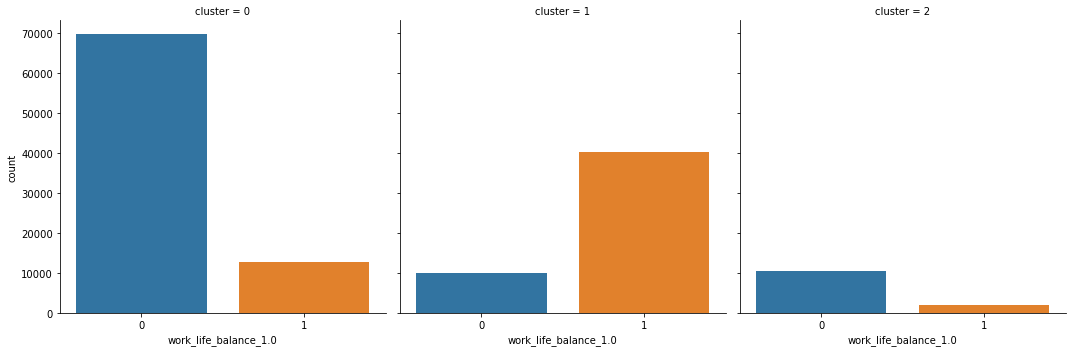

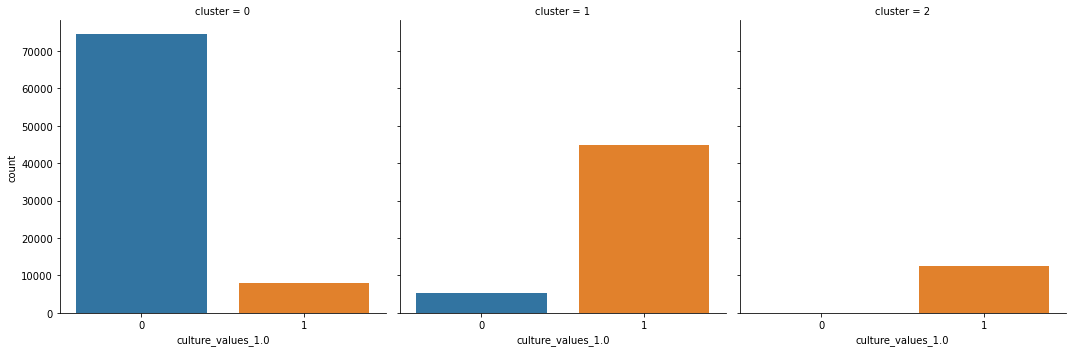

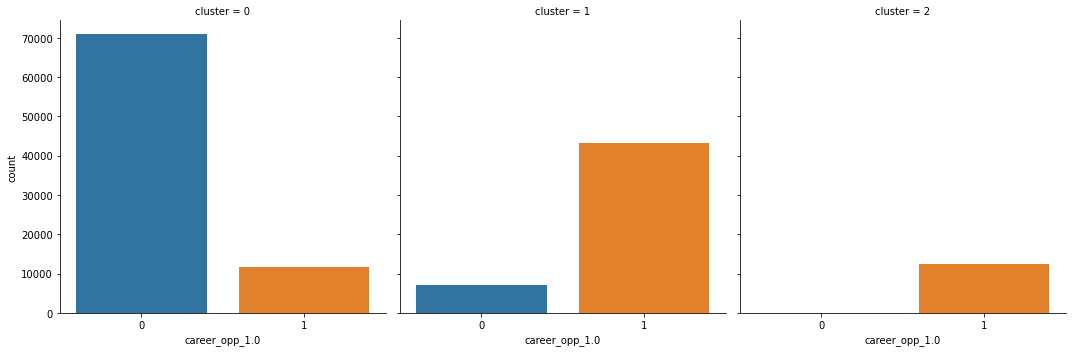

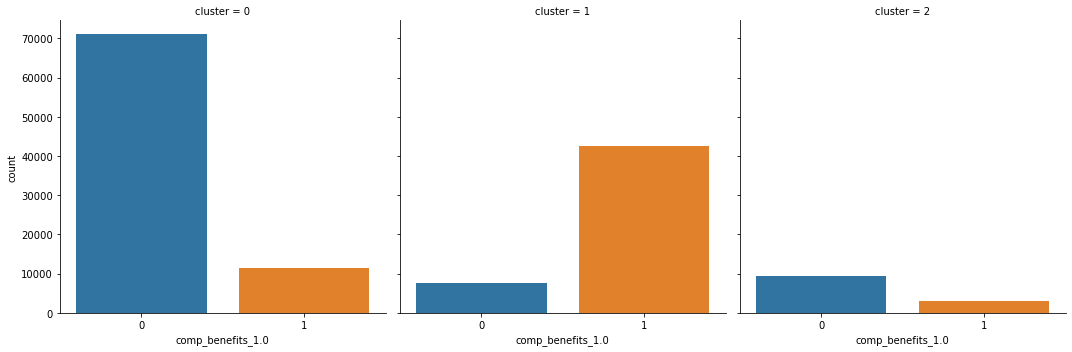

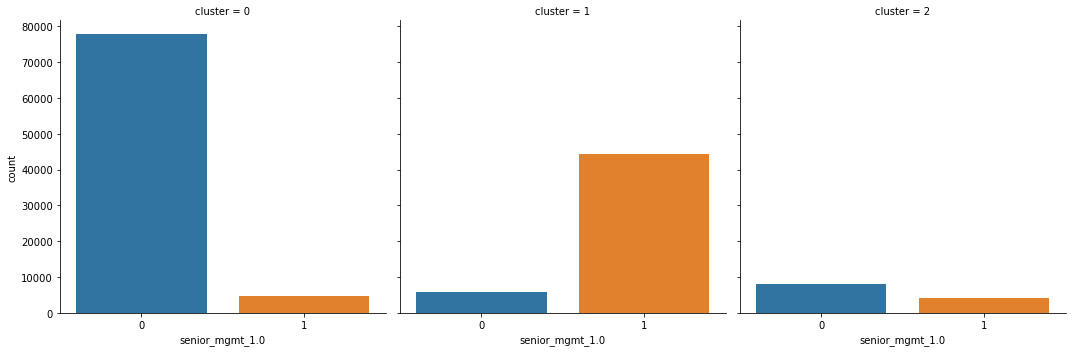

In [26]:
# Plot distributions of ratings across each cluster
for feature in feature_names:
    sns.catplot(x=feature, col = 'cluster',data=clusteringdf,kind="count")

## ASSOCIATION RULES MINING

In [27]:
# Create a new dataframe and drop job titles
ruleminingdf = clusteringdf.drop(columns=['job_title'])
ruleminingdf = pd.get_dummies(ruleminingdf, columns=['cluster']) # convert cluster column to dummy variables

In [28]:
# Get frequent itemsets with apriori
frequentitems = apriori(ruleminingdf, min_support = 0.005, use_colnames=True)
frequentitems.sort_values('support', ascending = False, inplace = True)
frequentitems.head(50)

# Create association rules from frequent itemsets with min confidence threshold of 0.6
rules = association_rules(frequentitems, metric = 'confidence', min_threshold=0.6)
rules = rules[rules['lift'] > 1.2] # filter away non-correlated or negatively corretled rules with lift < 1.2
rules.sort_values('lift', ascending = False, inplace = True)

/Users/gustavjandrup/opt/anaconda3/envs/BDP_EXERCISE1/lib/python3.8/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


<AxesSubplot:>

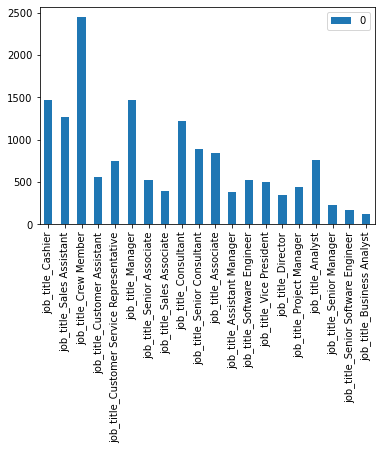

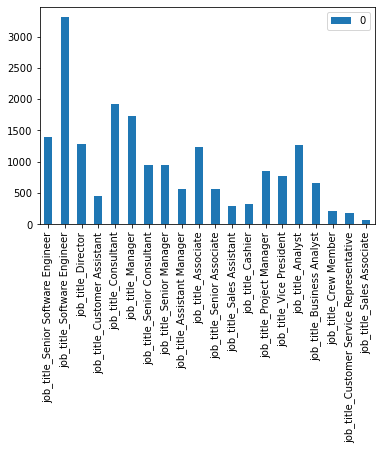

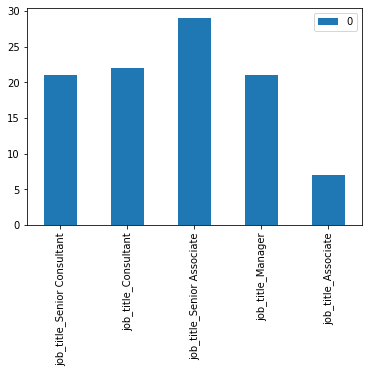

In [29]:
# Filter associations rules to only get antecdent itemsets containing job titles
jobs_antecedent = rules[rules['antecedents'].astype(str).str.lower().str.contains('job')]

# Get dataframe for each cluster containing their respective consequent
cluster_0_consequents = jobs_antecedent[jobs_antecedent['consequents'].astype(str).str.lower().str.contains("cluster_0")]
cluster_1_consequents = jobs_antecedent[jobs_antecedent['consequents'].astype(str).str.lower().str.contains("cluster_1")]
cluster_2_consequents = jobs_antecedent[jobs_antecedent['consequents'].astype(str).str.lower().str.contains("cluster_2")]
cluster_3_consequents = jobs_antecedent[jobs_antecedent['consequents'].astype(str).str.lower().str.contains("cluster_3")]

# plot cluster 0
job_titles_cluster_0 = [[item for item in _set if 'job' in item] for _set in cluster_0_consequents['antecedents']]
job_titles_cluster_0 = [i[0] for i in job_titles_cluster_0]


job_title_counts = Counter(job_titles_cluster_0)
clust0 = pd.DataFrame.from_dict(job_title_counts, orient='index')
clust0.plot(kind='bar')

# plot cluster 1
job_titles_cluster_1 = [[item for item in _set if 'job' in item] for _set in cluster_1_consequents['antecedents']]
job_titles_cluster_1 = [i[0] for i in job_titles_cluster_1]


job_title_counts = Counter(job_titles_cluster_1)
clust1 = pd.DataFrame.from_dict(job_title_counts, orient='index')
clust1.plot(kind='bar')


# plot cluster 2
job_titles_cluster_2 = [[item for item in _set if 'job' in item] for _set in cluster_2_consequents['antecedents']]
job_titles_cluster_2 = [i[0] for i in job_titles_cluster_2]


job_title_counts = Counter(job_titles_cluster_2)
clust2 = pd.DataFrame.from_dict(job_title_counts, orient='index')
clust2.plot(kind='bar')

In [30]:
jobs = [job for job in ruleminingdf if 'job' in job] # get list of job titles
cluster = [cluster for cluster in ruleminingdf if 'cluster' in cluster] # get list of clusters

features = jobs + cluster # create list of features

jobs_df = ruleminingdf[features] # create jobs_df with clusters

# Get frequent itemsets for dataframe containing only jobs and clusters
frequentitems2 = apriori(jobs_df, min_support = 0.005, use_colnames=True)
frequentitems2.sort_values('support', ascending = False, inplace = True)
frequentitems2.head(50)

# Get association rules of jobs and clusters from frequent items
rules2 = association_rules(frequentitems2, metric = 'confidence', min_threshold=0.6)
rules2 = rules2[rules2['lift'] > 1.2]
rules2.sort_values('lift', ascending = False, inplace = True)

/Users/gustavjandrup/opt/anaconda3/envs/BDP_EXERCISE1/lib/python3.8/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [31]:
job_titles = [column for column in ruleminingdf if 'job_title' in column] # get job titles

# Convert job titles to categorical column
categories = job_titles_df[job_titles_df==1].stack().reset_index().drop(0, axis=1)
cat = categories.drop(columns = 'level_0').rename(columns = {'level_1': 'job_title'})
cat['job_title'] = cat['job_title'].str.replace(r'job_title_', '')

# create job column
ruleminingdf['job'] = cat['job_title']

In [32]:
# define list to be given label "Business Professional"
business_professional = ['Analyst', 
                         'Senior Consultant', 
                         'Consultant', 
                         'Associate', 
                         'Senior Associate', 
                         'Business Analyst',
                         'Project Manager']

# define list to be given label "Technology Professional"
technology_professional = ['Software Engineer', 
                           'Senior Software Engineer']

# define list to be given label "Management Professional"
management_professional = ['Vice President', 
                           'Senior Manager', 
                           'Manager', 
                           'Assistant Manager',
                           'Director']

# define list to be given label "Service Professional"
service_professional = ['Crew Member', 
                        'Customer Assistant', 
                        'Customer Service Representative', 
                        'Cashier', 
                        'Crew Member',
                        'Sales Assistant',
                        'Sales Associate']

ruleminingdf['job'] = ruleminingdf['job'].replace(business_professional,'Business Professional')
ruleminingdf['job'] = ruleminingdf['job'].replace(technology_professional,'Technology Professional')
ruleminingdf['job'] = ruleminingdf['job'].replace(management_professional,'Management Professional')
ruleminingdf['job'] = ruleminingdf['job'].replace(service_professional,'Service Professional')

# Get new dummies with labels
ruleminingdf = ruleminingdf.drop(columns=job_titles)
ruleminingdf = pd.get_dummies(ruleminingdf, columns=['job'])

In [34]:
# Get frequent itemsets with apriori
labeled_frequentitems = apriori(ruleminingdf, min_support = 0.005, use_colnames=True)
frequentitems.sort_values('support', ascending = False, inplace = True)

# Get association rules
labeled_rules = association_rules(labeled_frequentitems, metric = 'confidence', min_threshold=0.6)
labeled_rules = labeled_rules[labeled_rules['lift'] > 1.2]
labeled_rules.sort_values('lift', ascending = False, inplace = True)

/Users/gustavjandrup/opt/anaconda3/envs/BDP_EXERCISE1/lib/python3.8/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


<AxesSubplot:>

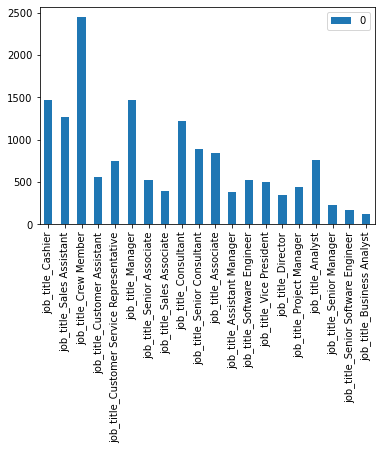

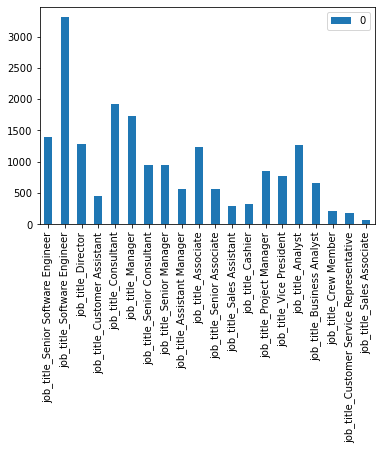

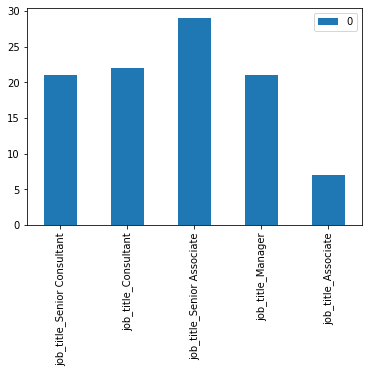

In [35]:
# Get association rules where label are included in the antecdent
jobs_antecedent = rules[rules['antecedents'].astype(str).str.lower().str.contains('job')]

# Get consequents for each cluster in a respective dataframe
cluster_0_consequents = jobs_antecedent[jobs_antecedent['consequents'].astype(str).str.lower().str.contains("cluster_0")]
cluster_1_consequents = jobs_antecedent[jobs_antecedent['consequents'].astype(str).str.lower().str.contains("cluster_1")]
cluster_2_consequents = jobs_antecedent[jobs_antecedent['consequents'].astype(str).str.lower().str.contains("cluster_2")]


# plot cluster 0
job_titles_cluster_0 = [[item for item in _set if 'job' in item] for _set in cluster_0_consequents['antecedents']]
job_titles_cluster_0 = [i[0] for i in job_titles_cluster_0]

job_title_counts = Counter(job_titles_cluster_0)
clust0 = pd.DataFrame.from_dict(job_title_counts, orient='index')
clust0.plot(kind='bar')


# plot cluster 1
job_titles_cluster_1 = [[item for item in _set if 'job' in item] for _set in cluster_1_consequents['antecedents']]
job_titles_cluster_1 = [i[0] for i in job_titles_cluster_1]

job_title_counts = Counter(job_titles_cluster_1)
clust1 = pd.DataFrame.from_dict(job_title_counts, orient='index')
clust1.plot(kind='bar')


# plot cluster 2
job_titles_cluster_2 = [[item for item in _set if 'job' in item] for _set in cluster_2_consequents['antecedents']]
job_titles_cluster_2 = [i[0] for i in job_titles_cluster_2]

job_title_counts = Counter(job_titles_cluster_2)
clust2 = pd.DataFrame.from_dict(job_title_counts, orient='index')
clust2.plot(kind='bar')

In [36]:
jobs = [job for job in ruleminingdf if 'job' in job] # get list of label variabels
cluster = [cluster for cluster in ruleminingdf if 'cluster' in cluster] # get list of cluster variables

features = jobs + cluster # create list of features

labeled_jobs_df = ruleminingdf[features] # get dataframe from features

# Get frequent itemsets for dataframe containing only jobs and clusters
labeled_frequentitems2 = apriori(labeled_jobs_df, min_support = 0.005, use_colnames=True)
labeled_frequentitems2.sort_values('support', ascending = False, inplace = True)

# Get association rules containing only jobs and clusters
labeled_rules2 = association_rules(labeled_frequentitems2, metric = 'confidence', min_threshold=0.6)
labeled_rules2 = labeled_rules2[labeled_rules2['lift'] > 1.2]
labeled_rules2.sort_values('lift', ascending = False, inplace = True)

/Users/gustavjandrup/opt/anaconda3/envs/BDP_EXERCISE1/lib/python3.8/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


# Supervised ML Models: Model Collection & Logistic Regression

## MODELLING THE MODEL COLLECTION

In [74]:
# Create dataframe for modelling the model collection
algoevaluationdf = modeldf[modeldf['job_title'].str.fullmatch('Manager|Consultant|Software Engineer|Associate|Senior Consultant|Analyst|Crew Member|Senior Associate|Cashier|Project Manager|Senior Manager|Vice President|Sales Assistant|Customer Assistant|Director|Assistant Manager|Senior Software Engineer|Business Analyst|Customer Service Representative|Sales Associate') == True]

# Reset dataframe index from 0
algoevaluationdf = algoevaluationdf.reset_index(drop=True)

In [75]:
# Get dummies / Use one-hot encoding to get features describing job titles
algoevaluationdf = pd.get_dummies(algoevaluationdf, columns=['job_title'])

In [76]:
# Get dummmies for 'tenure' and 'current' columns
algoevaluationdf = pd.get_dummies(algoevaluationdf, columns=['tenure'])
algoevaluationdf = pd.get_dummies(algoevaluationdf, columns=['current'])

In [77]:
# Dropping columns not used for the model function
algoevaluationdf = algoevaluationdf.drop(['overall_rating', 'firm', 'date_review', 'location', 'recommend', 'ceo_approv', 'outlook', 'headline', 'pros', 'cons'], axis = 1)

In [78]:
algoevaluationdf = algoevaluationdf.reindex(columns = [col for col in algoevaluationdf.columns if col != 'career_opp'] + ['career_opp'])
algoevaluationdf = algoevaluationdf.reindex(columns = [col for col in algoevaluationdf.columns if col != 'work_life_balance'] + ['work_life_balance'])
algoevaluationdf = algoevaluationdf.reindex(columns = [col for col in algoevaluationdf.columns if col != 'senior_mgmt'] + ['senior_mgmt'])
algoevaluationdf = algoevaluationdf.reindex(columns = [col for col in algoevaluationdf.columns if col != 'comp_benefits'] + ['comp_benefits'])
algoevaluationdf = algoevaluationdf.reindex(columns = [col for col in algoevaluationdf.columns if col != 'culture_values'] + ['culture_values'])

In [79]:
algoevaluationdf.dropna(inplace = True)
algoevaluationdf.astype('int')

,job_title_Analyst,job_title_Assistant Manager,job_title_Associate,job_title_Business Analyst,job_title_Cashier,job_title_Consultant,job_title_Crew Member,job_title_Customer Assistant,job_title_Customer Service Representative,job_title_Director,...,tenure_3,tenure_5,tenure_8,current_0,current_1,career_opp,work_life_balance,senior_mgmt,comp_benefits,culture_values
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,1,1,1
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,1,1,1,1,1
5,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145056,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
145057,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
145058,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,1,1,1,1
145059,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,1,0,1


In [84]:
def algoevaluation(x, title, dataset, models):
    
    array = dataset.values
    X = array[:, :-1] #The current slice allows the for loop to iterate over the same list size
    y = array[:, -1]
    
    # split dataset into training and test data
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.30, random_state = 1)
    
    # Evaluate each model through a loop function 
    total = [] # stores model and accuracy score
    results = []
    test_results = []
    names = []
    scoring = 'accuracy'
    
    print(title + '\n' + '----------------------------------------------------' + '\n')        
    for name, model in models:
        #kfold = model_selection.KFold(n_splits = 10)
        kfold = RepeatedStratifiedKFold(n_splits = 10)
        cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        total.append([name, cv_results]) 
        
        #model.fit(X_train, Y_train)
        #yhat = model.predict(X_test)
        #accuracyscore = metrics.accuracy_score(Y_test, yhat)
        #test_results.append(accuracyscore)
        #mess = "%s accuracy, testset: %f" % (name, accuracyscore)
        
        print(msg)
        #print(mess)
    
    # Compare Algorithms
    plt.boxplot(results, labels=names)
    plt.title('Algorithm Comparison')
    plt.show()
    
    return X_train, X_test, Y_train, Y_test, total, results, names

Predicting Compensation & Benefits
----------------------------------------------------

Prior: 0.514784 (0.000054)
LR: 0.564755 (0.005138)
LDA: 0.564768 (0.004799)
BNB: 0.560208 (0.005098)
DTC: 0.566017 (0.005070)
KNN: 0.537234 (0.006861)
RF: 0.566297 (0.005858)


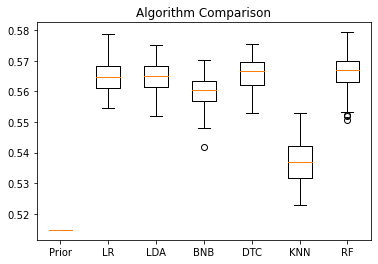

Predicting Career Opportunities
----------------------------------------------------

Prior: 0.571300 (0.000053)
LR: 0.629636 (0.004542)
LDA: 0.629573 (0.004678)
BNB: 0.614553 (0.005035)
DTC: 0.632850 (0.004347)
KNN: 0.577038 (0.009196)
RF: 0.632633 (0.004943)


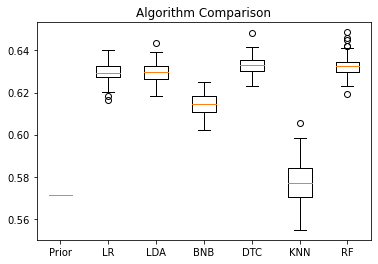

Predicting Work/Life Balance
----------------------------------------------------

Prior: 0.539112 (0.000034)
LR: 0.602042 (0.005224)
LDA: 0.601989 (0.005107)
BNB: 0.600545 (0.005329)
DTC: 0.603001 (0.004952)
KNN: 0.550770 (0.007148)
RF: 0.602779 (0.004816)


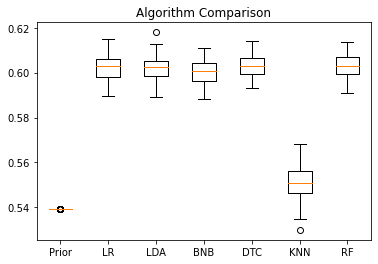

Predicting Senior Management
----------------------------------------------------

Prior: 0.545423 (0.000036)
LR: 0.574381 (0.005002)
LDA: 0.574481 (0.005039)
BNB: 0.568765 (0.006283)
DTC: 0.576701 (0.005276)
KNN: 0.537017 (0.006516)
RF: 0.576928 (0.005380)


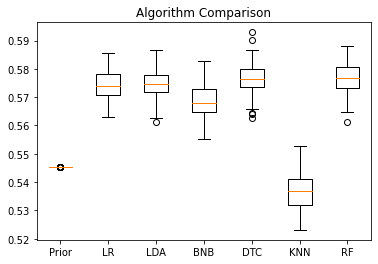

Predicting Culture & Values
----------------------------------------------------

Prior: 0.581999 (0.000049)
LR: 0.611391 (0.004034)
LDA: 0.611237 (0.004774)
BNB: 0.597912 (0.005828)
DTC: 0.616307 (0.004539)
KNN: 0.566793 (0.006992)
RF: 0.616728 (0.004215)


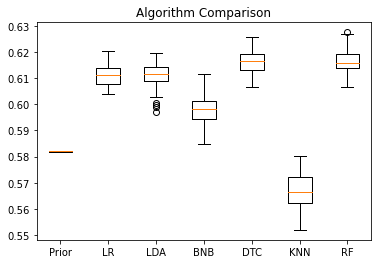

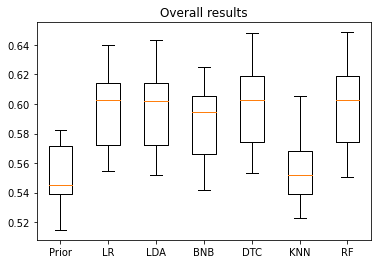

In [81]:
# Append algorithm
models = []

# Naive algorithm
#models.append(('Uniformly RG', DummyClassifier(strategy='uniform')))
#models.append(('Prior RG', DummyClassifier(strategy='stratified')))
#models.append(('Majority Class: Predict 1', DummyClassifier(strategy='most_frequent')))
#models.append(('Minority Class: Predict 0', DummyClassifier(strategy='constant', constant=0)))
models.append(('Prior', DummyClassifier(strategy='prior')))

# Linear algorithm
models.append(('LR', LogisticRegression(max_iter = 1000)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('BNB', BernoulliNB()))
# Nonlinear algorithms
models.append(('DTC', DecisionTreeClassifier()))
models.append(('KNN', KNeighborsClassifier()))
#models.append(('SVC', SVC()))

# Ensemble algorithms
models.append(('RF', RandomForestClassifier()))

x = 0

overallresults = [[] for r in models]


for i in range(0, 5):
    if x == 0:
        algo_comparison1 = algoevaluationdf.drop(['culture_values', 'senior_mgmt', 'career_opp', 'work_life_balance'], axis = 1) # predict comp_benefits
        dataset = algo_comparison1

        title = 'Predicting Compensation & Benefits'

        x = 1 + x

    elif x == 1: 
        algo_comparison2 = algoevaluationdf.drop(['culture_values', 'senior_mgmt', 'work_life_balance', 'comp_benefits'], axis = 1) # predict career_opp
        dataset = algo_comparison2

        title = 'Predicting Career Opportunities'

        x = 1 + x
        
    elif x == 2: 
        algo_comparison3 = algoevaluationdf.drop(['culture_values', 'senior_mgmt', 'career_opp', 'comp_benefits'], axis = 1) # predict work_life_balance
        dataset = algo_comparison3

        title = 'Predicting Work/Life Balance'

        x = 1 + x
    
    elif x == 3: 
        algo_comparison4 = algoevaluationdf.drop(['culture_values', 'career_opp', 'work_life_balance', 'comp_benefits'], axis = 1) # predict senior_mgmt
        dataset = algo_comparison4

        title = 'Predicting Senior Management'

        x = 1 + x

    else:
        algo_comparison5 = algoevaluationdf.drop(['senior_mgmt', 'career_opp', 'work_life_balance', 'comp_benefits'], axis = 1) # predict culture_values
        dataset = algo_comparison5

        title = 'Predicting Culture & Values'

    X_train, X_test, Y_train, Y_test, total, results, names = algoevaluation(x, title, dataset, models)   
    
    for r in range(len(results)):
        overallresults[r].extend(results[r])
        
modelnames = [m[0] for m in models]

plt.boxplot(overallresults, labels = modelnames)
plt.title('Overall results')
plt.show()

Predicting Compensation & Benefits
----------------------------------------------------

Prior: 0.514784 (0.000054)
LR: 0.533596 (0.004628)
LDA: 0.533720 (0.004371)
BNB: 0.534582 (0.005601)
DTC: 0.536279 (0.005702)
KNN: 0.514930 (0.006260)
RF: 0.536501 (0.005511)


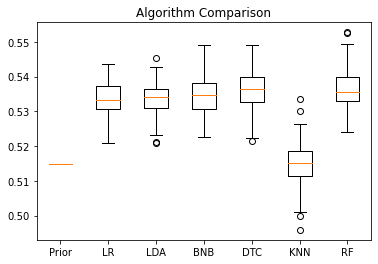

Predicting Career Opportunities
----------------------------------------------------

Prior: 0.571300 (0.000053)
LR: 0.594354 (0.003966)
LDA: 0.594295 (0.004685)
BNB: 0.581840 (0.005757)
DTC: 0.594650 (0.004251)
KNN: 0.558031 (0.010939)
RF: 0.594659 (0.004552)


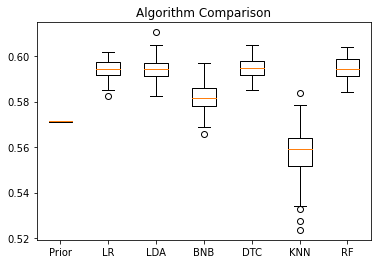

Predicting Work/Life Balance
----------------------------------------------------

Prior: 0.539112 (0.000034)
LR: 0.553645 (0.004644)
LDA: 0.553734 (0.004971)
BNB: 0.546362 (0.004935)
DTC: 0.552126 (0.004259)
KNN: 0.516223 (0.007778)
RF: 0.552267 (0.004365)


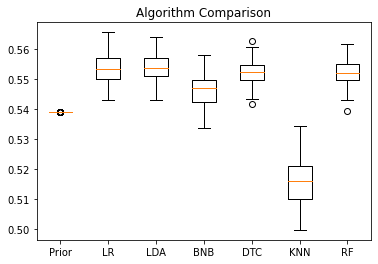

Predicting Senior Management
----------------------------------------------------

Prior: 0.545423 (0.000036)
LR: 0.562695 (0.005083)
LDA: 0.562472 (0.005177)
BNB: 0.553192 (0.004681)
DTC: 0.565746 (0.003863)
KNN: 0.523071 (0.008682)
RF: 0.565745 (0.005293)


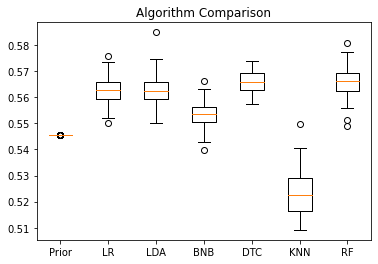

Predicting Culture & Values
----------------------------------------------------

Prior: 0.581999 (0.000049)
LR: 0.595917 (0.004357)
LDA: 0.594876 (0.004082)
BNB: 0.588026 (0.005287)
DTC: 0.594736 (0.004153)
KNN: 0.552534 (0.010556)
RF: 0.594458 (0.004482)


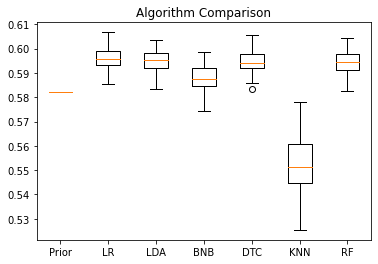

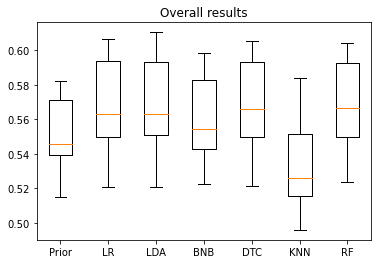

In [85]:
x = 0

overallresults = [[] for r in models]

for i in range(0, 5):
    if x == 0:
        algo_comparison1 = algoevaluationdf2.drop(['culture_values', 'senior_mgmt', 'career_opp', 'work_life_balance'], axis = 1) # predict comp_benefits
        dataset = algo_comparison1

        title = 'Predicting Compensation & Benefits'

        x = 1 + x

    elif x == 1: 
        algo_comparison2 = algoevaluationdf2.drop(['culture_values', 'senior_mgmt', 'work_life_balance', 'comp_benefits'], axis = 1) # predict career_opp
        dataset = algo_comparison2

        title = 'Predicting Career Opportunities'

        x = 1 + x
        
    elif x == 2: 
        algo_comparison3 = algoevaluationdf2.drop(['culture_values', 'senior_mgmt', 'career_opp', 'comp_benefits'], axis = 1) # predict work_life_balance
        dataset = algo_comparison3

        title = 'Predicting Work/Life Balance'

        x = 1 + x
    
    elif x == 3: 
        algo_comparison4 = algoevaluationdf2.drop(['culture_values', 'career_opp', 'work_life_balance', 'comp_benefits'], axis = 1) # predict senior_mgmt
        dataset = algo_comparison4

        title = 'Predicting Senior Management'

        x = 1 + x

    else:
        algo_comparison5 = algoevaluationdf2.drop(['senior_mgmt', 'career_opp', 'work_life_balance', 'comp_benefits'], axis = 1) # predict culture_values
        dataset = algo_comparison5

        title = 'Predicting Culture & Values'

    X_train, X_test, Y_train, Y_test, total, results, names = algoevaluation(x, title, dataset, models)   
    
    for r in range(len(results)):
        overallresults[r].extend(results[r])
        
modelnames = [m[0] for m in models]

plt.boxplot(overallresults, labels = modelnames)
plt.title('Overall results')
plt.show()

## HYPERPARAMETER OPTIMIZATION WITH RANDOMSEARCHCV
### a) APPLIED ON DATASET WITH JOB TITLES

In [49]:
# algoevaluationdf is the dataset with job titles remaining, or the original, before we've applied labeling.
# I redefine a version of algoevaluationdf wherein one of the ratings remains while the rest are dropped
comp_benefits_cv = algoevaluationdf.drop(['culture_values', 'senior_mgmt', 'career_opp', 'work_life_balance'], axis = 1) # dataset = comp_benefits
career_opp_cv = algoevaluationdf.drop(['culture_values', 'senior_mgmt', 'work_life_balance', 'comp_benefits'], axis = 1) # dataset = career_opp
work_life_balance_cv = algoevaluationdf.drop(['culture_values', 'senior_mgmt', 'career_opp', 'comp_benefits'], axis = 1) # dataset = work_life_balance
senior_mgmt_cv = algoevaluationdf.drop(['culture_values', 'career_opp', 'work_life_balance', 'comp_benefits'], axis = 1) # dataset =  senior_mgmt
culture_values_cv = algoevaluationdf.drop(['senior_mgmt', 'career_opp', 'work_life_balance', 'comp_benefits'], axis = 1) # dataset = culture_values

In [50]:
# Jeg har lavet den her funktion og brugt den til at kalde på hver af de ovenstående dataframes
def tune_logistic_regression(dataset):
    # First we define our variables to hold our model and our grid
    array = dataset.values
    X = array[:, 0:28] ##28 for baseline
    y = array[:, 28]

    # define the model 
    model = LogisticRegression()

    # define search space for gridsearchcv
    space = dict()
    space['solver'] = ['lbfgs', 'newton-cholesky', 'sag']
    space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
    space['C'] = list(np.arange (0, 1, 0.1))

    # define evaluation parameter, in our case Kfold
    cv = KFold(n_splits=10)

    search = RandomizedSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv)

    # instantiate search by calling fit function
    result = search.fit(X, y)

    # store best hyperparameters and score in variables
    best_params = result.best_params_
    best_score = result.best_score_
    # summarize results
    print('Best Score: %s' % result.best_score_)
    print('Best Hyperparameters: %s' % result.best_params_)
    
    return model, search, result

In [51]:
#Her har jeg lavet et for loop som går ind i en liste af datasets og kører hver liste med funktionen og returner derefter outputtet nedenunder.
# Then I define a list of the datasets
datasets = [comp_benefits_cv, career_opp_cv, work_life_balance_cv, senior_mgmt_cv, culture_values_cv]

# create an empty list to store the results
results = []

# iterate over the datasets
for dataset in datasets:
  # call the tune_logistic_regression function and store the result
  result = tune_logistic_regression(dataset)
  # append the result to the results list
  results.append(result)

Best Score: 0.5555425060981117
Best Hyperparameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.4}
Best Score: 0.6273827807390008
Best Hyperparameters: {'solver': 'sag', 'penalty': 'none', 'C': 0.2}
Best Score: 0.5973620019875326
Best Hyperparameters: {'solver': 'sag', 'penalty': 'l2', 'C': 0.30000000000000004}
Best Score: 0.5682898184117807
Best Hyperparameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.2}
Best Score: 0.6100822115818954
Best Hyperparameters: {'solver': 'sag', 'penalty': 'l2', 'C': 0.2}


In [52]:
#Calling function on data with job titles --- Her kalder jeg funktionen og printer teksten på alle ratings 

print ('Company Benefits results ----------')

tune_logistic_regression(comp_benefits_cv)

print ('Career Opportunities results ----------')

tune_logistic_regression(career_opp_cv)

print ('Work Life Balance results ----------')

tune_logistic_regression(work_life_balance_cv)

print ('Senior Management results ----------')

tune_logistic_regression(senior_mgmt_cv)

print ('Culture Values results ----------')

tune_logistic_regression(culture_values_cv)


print ('End of code')

Company Benefits results ----------
Best Score: 0.5554792664197307
Best Hyperparameters: {'solver': 'sag', 'penalty': 'l2', 'C': 0.6000000000000001}
Career Opportunities results ----------
Best Score: 0.6273918149787695
Best Hyperparameters: {'solver': 'sag', 'penalty': 'l2', 'C': 0.1}
Work Life Balance results ----------
Best Score: 0.5973710362273015
Best Hyperparameters: {'solver': 'sag', 'penalty': 'none', 'C': 0.1}
Senior Management results ----------
Best Score: 0.5683891950492367
Best Hyperparameters: {'solver': 'sag', 'penalty': 'none', 'C': 0.7000000000000001}
Culture Values results ----------
Best Score: 0.6101002800614328
Best Hyperparameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.4}
End of code


### b) APPLIED ON DATASET WITH LABELS

In [53]:
# Create list of columns containing job titles
job_titles = [column for column in algoevaluationdf 
                if 'job_title' in column]

job_titles_df = algoevaluationdf[job_titles] # get job title dataframe

# Convert job titles to categorical column
categories = job_titles_df[job_titles_df==1].stack().reset_index().drop(0, axis=1)
cat = categories.drop(columns = 'level_0').rename(columns = {'level_1': 'job_title'})
cat['job_title'] = cat['job_title'].str.replace(r'job_title_', '')

# create job column
algoevaluationdf['job'] = cat['job_title']

In [56]:
# Defines new dataframe for hyperparameter search on dataset with labels
algoevaluationdf2 = algoevaluationdf.rename(columns={'job_title': 'job'})

In [57]:
#Replace job titles with labels

business_professional = ['Analyst', 
                         'Senior Consultant', 
                         'Consultant', 
                         'Associate', 
                         'Senior Associate', 
                         'Business Analyst',
                         'Project Manager']

technology_professional = ['Software Engineer', 
                           'Senior Software Engineer']

management_professional = ['Vice President', 
                           'Senior Manager', 
                           'Manager', 
                           'Assistant Manager',
                           'Director']

service_professional = ['Crew Member', 
                        'Customer Assistant', 
                        'Customer Service Representative', 
                        'Cashier', 
                        'Crew Member',
                        'Sales Assistant',
                        'Sales Associate']

algoevaluationdf2['job'] = algoevaluationdf2['job'].replace(business_professional,'Business Professional')
algoevaluationdf2['job'] = algoevaluationdf2['job'].replace(technology_professional,'Technology Professional')
algoevaluationdf2['job'] = algoevaluationdf2['job'].replace(management_professional,'Management Professional')
algoevaluationdf2['job'] = algoevaluationdf2['job'].replace(service_professional,'Service Professional')


algoevaluationdf2 = algoevaluationdf2.drop(columns=job_titles)
algoevaluationdf2 = pd.get_dummies(algoevaluationdf2, columns=['job'])

In [58]:
algoevaluationdf2 = (algoevaluationdf2
           .pipe(lambda df: df.reindex(columns=[col for col in df.columns if col != 'work_life_balance'] + ['work_life_balance']))
           .pipe(lambda df: df.reindex(columns=[col for col in df.columns if col != 'senior_mgmt'] + ['senior_mgmt']))
           .pipe(lambda df: df.reindex(columns=[col for col in df.columns if col != 'comp_benefits'] + ['comp_benefits']))
           .pipe(lambda df: df.reindex(columns=[col for col in df.columns if col != 'culture_values'] + ['culture_values']))
           .pipe(lambda df: df.reindex(columns=[col for col in df.columns if col != 'career_opp'] + ['career_opp'])))

In [59]:
def labeled_tuning(dataset):
    array = dataset.values
    X = array[:, 0:12] ##28 for baseline
    y = array[:, 12]

# define the model 
    model = LogisticRegression()

    # define search space for gridsearchcv
    space = dict()
    space['solver'] = ['lbfgs', 'newton-cholesky', 'sag']
    space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
    space['C'] = list(np.arange (0, 1, 0.1))

    # define evaluation parameter, in our case Kfold
    cv = KFold(n_splits=10)

    # define GridSearchCV
    #search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv)
    search = RandomizedSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv)

    # instantiate search by calling fit function
    result = search.fit(X, y)

    # store best hyperparameters and score in variables
    best_params = result.best_params_
    best_score = result.best_score_
    
    # summarize results
    print('Best Score: %s' % result.best_score_)
    print('Best Hyperparameters for labeled data: %s' % result.best_params_)
    
    return model, search, result, best_params, best_score

In [60]:
labeled_tuning(algoevaluationdf2)

Best Score: 0.5004336435088987
Best Hyperparameters for labeled data: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.1}


(LogisticRegression(),
 RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                    estimator=LogisticRegression(), n_jobs=-1,
                    param_distributions={'C': [0.0, 0.1, 0.2,
                                               0.30000000000000004, 0.4, 0.5,
                                               0.6000000000000001,
                                               0.7000000000000001, 0.8, 0.9],
                                         'penalty': ['none', 'l1', 'l2',
                                                     'elasticnet'],
                                         'solver': ['lbfgs', 'newton-cholesky',
                                                    'sag']},
                    scoring='accuracy'),
 RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                    estimator=LogisticRegression(), n_jobs=-1,
                    param_distributions={'C': [0.0, 0.1, 0.2,
                           

In [61]:
#Drop columns for algoevaluationdf2
comp_benefits1_cv = algoevaluationdf2.drop(['culture_values', 'senior_mgmt', 'career_opp', 'work_life_balance'], axis = 1) # dataset = comp_benefits
career_opp1_cv = algoevaluationdf2.drop(['culture_values', 'senior_mgmt', 'work_life_balance', 'comp_benefits'], axis = 1) # dataset = career_opp
work_life_balance1_cv = algoevaluationdf2.drop(['culture_values', 'senior_mgmt', 'career_opp', 'comp_benefits'], axis = 1) # dataset = work_life_balance
senior_mgmt1_cv = algoevaluationdf2.drop(['culture_values', 'career_opp', 'work_life_balance', 'comp_benefits'], axis = 1) # dataset =  senior_mgmt
culture_values1_cv = algoevaluationdf2.drop(['senior_mgmt', 'career_opp', 'work_life_balance', 'comp_benefits'], axis = 1) # dataset = culture_values

In [62]:
#Calling function on labeled data

print ('Company Benefits results ----------')

labeled_tuning(comp_benefits1_cv)

print ('Career Opportunities results ----------')

labeled_tuning(career_opp1_cv)

print ('Work Life Balance results ----------')

labeled_tuning(work_life_balance1_cv)

print ('Senior Management results ----------')

labeled_tuning(senior_mgmt1_cv)

print ('Culture Values results ----------')

labeled_tuning(culture_values1_cv)

print ('End of code')

Company Benefits results ----------
Best Score: 0.5149787695365434
Best Hyperparameters for labeled data: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.0}
Career Opportunities results ----------
Best Score: 0.5593730237600505
Best Hyperparameters for labeled data: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.9}
Work Life Balance results ----------
Best Score: 0.5004336435088987
Best Hyperparameters for labeled data: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.9}
Senior Management results ----------
Best Score: 0.5493269491372301
Best Hyperparameters for labeled data: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.30000000000000004}
Culture Values results ----------
Best Score: 0.5829885265154937
Best Hyperparameters for labeled data: {'solver': 'lbfgs', 'penalty': 'none', 'C': 0.7000000000000001}
End of code


## OPTIMIZED LOGISTIC REGRESSION

In [104]:
# Defining final job title dataframe
logisticregdf_titles = algoevaluationdf.drop(columns = ['job'])

y_variables = ['career_opp', 'work_life_balance', 'senior_mgmt', 'comp_benefits', 'culture_values']
x_variables = [x for x in logisticregdf_titles if not x in y_variables]

X_train, X_test, y_train, y_test = train_test_split(logisticregdf_titles[x_variables],logisticregdf_titles[y_variables], test_size=0.3, random_state=42)

job_features = [x for x in x_variables if 'job' in x] # X

table_dict = {'feature': x_variables}

job_table = {'job': job_features} # X

for y in y_variables:
    col_idx = logisticregdf_titles.columns.get_loc(y)
                                               
    model = LogisticRegression(solver='sag', penalty='l2', C=0.3)                                          
    model.fit(X_train, y_train[y])
    
    coefs = list(zip(model.feature_names_in_, model.coef_[0]))
    
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
                                                   
    training_accuracy = accuracy_score(y_train[y], train_predictions)
    test_accuracy = accuracy_score(y_test[y], test_predictions)
    
    print(y)
    print("-"*50)
    print('\n')
    print(f'Training Accuracy: {training_accuracy}')
    print(f'Test Accuracy: {test_accuracy}')
    print('\n')
    
    for name, coef in coefs:
        print(f"{name}: {coef}")
        
    print('\n') 
    
    accuracy_df = X_test.copy(deep = True) #X
    accuracy_df['predicted'] = model.predict(accuracy_df) #X
    accuracy_df['actual'] = y_test[y]
    
    accuracy_list = [] #X
    for job in job_features: #X
        filtered = accuracy_df.loc[accuracy_df[job] == 1] #X
        job_accuracy = accuracy_score(filtered['actual'], filtered['predicted']) #X
        accuracy_list.append(job_accuracy) #X
        
        
    job_table[y] = accuracy_list #X
    
    
    table_dict[y] = list(model.coef_[0])
    
table = pd.DataFrame.from_dict(table_dict)
accuracy_table = pd.DataFrame.from_dict(job_table)
    

career_opp
--------------------------------------------------


Training Accuracy: 0.6301382238684615
Test Accuracy: 0.6302887945312735


job_title_Analyst: 0.16053156297070895
job_title_Assistant Manager: 0.31357579518064344
job_title_Associate: 0.4835737727719001
job_title_Business Analyst: 0.21794108034163698
job_title_Cashier: -0.6188059848945724
job_title_Consultant: 0.6099785310468521
job_title_Crew Member: -0.7550994538980692
job_title_Customer Assistant: -0.6706501286635144
job_title_Customer Service Representative: -0.6014699721893031
job_title_Director: 0.19281402519839197
job_title_Manager: 0.2935923437390335
job_title_Project Manager: -0.1158511736504337
job_title_Sales Assistant: -0.8688912535056716
job_title_Sales Associate: -0.47948883559000594
job_title_Senior Associate: 0.632448971472378
job_title_Senior Consultant: 0.5163282128718226
job_title_Senior Manager: 0.33872183159743385
job_title_Senior Software Engineer: 0.10804051692931457
job_title_Software Engineer: 0.322

In [105]:
#define final dataframe for dataset with label

logisticregdf_label = algoevaluationdf2

#define x & y

y_variables_labeled = ['career_opp', 'work_life_balance', 'senior_mgmt', 'comp_benefits', 'culture_values']
x_variables_labeled = [x for x in logisticregdf_label if not x in y_variables_labeled]

job_features = [x for x in x_variables_labeled if 'job' in x]

table_dict = {'feature': x_variables_labeled}

job_table = {'job': job_features} # X

X_train, X_test, y_train, y_test = train_test_split(logisticregdf_label[x_variables_labeled],logisticregdf_label[y_variables_labeled], test_size=0.3, random_state=42)

for y in y_variables:
    col_idx = logisticregdf_label.columns.get_loc(y)
                                               
    model = LogisticRegression(solver='sag', penalty='l2', C=0.3)                                          
    model.fit(X_train, y_train[y])
    
    coefs = list(zip(model.feature_names_in_, model.coef_[0]))
    
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
                                                   
    training_accuracy = accuracy_score(y_train[y], train_predictions)
    test_accuracy = accuracy_score(y_test[y], test_predictions)
    
    print(y)
    print("-"*50)
    print('\n')
    print(f'Training Accuracy: {training_accuracy}')
    print(f'Test Accuracy: {test_accuracy}')
    print('\n')
    
    for name, coef in coefs:
        print(f"{name}: {coef}")
        
    print('\n')
    
    accuracy_df = X_test.copy(deep = True) #X
    accuracy_df['predicted'] = model.predict(accuracy_df) #X
    accuracy_df['actual'] = y_test[y]
    
    accuracy_list = [] #X
    for job in job_features: #X
        filtered = accuracy_df.loc[accuracy_df[job] == 1] #X
        job_accuracy = accuracy_score(filtered['actual'], filtered['predicted']) #X
        accuracy_list.append(job_accuracy) #X
        
        
    job_table[y] = accuracy_list #X
    
    
    table_dict[y] = list(model.coef_[0])
    
table = pd.DataFrame.from_dict(table_dict)
accuracy_table = pd.DataFrame.from_dict(job_table)   
                               

career_opp
--------------------------------------------------


Training Accuracy: 0.5920653562716983
Test Accuracy: 0.5963501671334357


tenure_0: -0.26642223899813944
tenure_1: -0.15063432646702338
tenure_10: -0.19851841241478638
tenure_3: 0.011789395683731444
tenure_5: 0.009593531629547326
tenure_8: -0.0592342729048871
current_0: -0.27260532913197993
current_1: 0.27259881760664595
job_Business Professional: 0.14929278808423296
job_Management Professional: 0.11409980015622688
job_Service Professional: 0.09040736187168832
job_Technology Professional: 0.3026598665764578


work_life_balance
--------------------------------------------------


Training Accuracy: 0.5529470980731257
Test Accuracy: 0.5520522781341284


tenure_0: 0.07132218181631877
tenure_1: -0.026802405418714946
tenure_10: 0.06952730519135272
tenure_3: -0.06213454631813382
tenure_5: 0.017645133891654778
tenure_8: 0.016742230888232547
current_0: -0.18235183805964786
current_1: 0.18234145413045583
job_Business Professional: 